In [1]:
import pyqsp
from pyqsp.LPoly import *
from pyqsp.gadgets import *
import jax
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm
from scipy.interpolate import approximate_taylor_polynomial
from matplotlib import pyplot as plt
import copy

np.set_printoptions(linewidth=100000)

In [2]:
import pennylane as qml

dev = qml.device('default.qubit', wires=[("a", 0), 2])
@qml.qnode(dev)
def fn():
    qml.ControlledQubitUnitary(np.array([[0, 1], [1, 0]]), control_wires=[('a', 0)], wires=[2])
    return qml.state()

fn()

tensor([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], requires_grad=True)

In [3]:
# Defines two atomic gadget

Xi_1 = [np.array([0, np.pi/3, -np.pi/3, 0])]
S_1 = [[0, 1, 0]]
G = AtomicGadget(Xi_1, S_1, label="G")

Xi_2 = np.array([[np.pi/5, np.pi/6, np.pi/6, -np.pi/4]])
S_2 = [[1, 0, 1]]
G_tilde = AtomicGadget(Xi_2, S_2, label="G_tilde")

In [4]:
# Performs an interlink of the G gadget with the extraction gadget. Note that deg is the 
# degree of the polynomial used in the correction. If it were instead "None" no correction
# would be applied
deg = 20

G_interlink = G.interlink(G_tilde, [
    (('G', 0), ('G_tilde', 0), deg)
])

In [5]:
print("In legs = {}".format(G_interlink.in_labels))
print("Out legs = {}".format(G_interlink.out_labels))

In legs = [('G', 0), ('G', 1), ('G_tilde', 1)]
Out legs = [('G_tilde', 0)]


In [6]:
# Sets gadget leg inputs
F = lambda x, y : {("G", 0): x, ("G", 1): y, ("G_tilde", 1): 0.5}

In [7]:
# Gets the sequence of a leg of the gadget interlink
fn = lambda x, y : G_interlink.get_qsp_unitary(('G_tilde', 0))(F(x, y))[0][0]

In [8]:
# Plots the gadget interlink
data = [[fn(x, y) for x in np.linspace(-1, 1, 20)] for y in tqdm(np.linspace(-1, 1, 20))]

  0%|          | 0/20 [00:00<?, ?it/s]

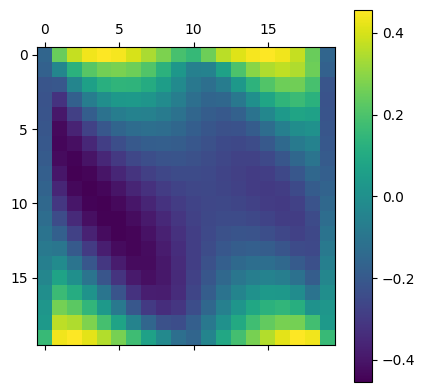

In [9]:
plt.matshow(np.real(data))
plt.colorbar()

In [15]:
# Performs tests of the extraction and sqrt gadgets
G_extraction = ExtractionGadget(29, 'G_ext')
G_sqrt = SqrtGadget(40, 0.06, 'G_sqrt')

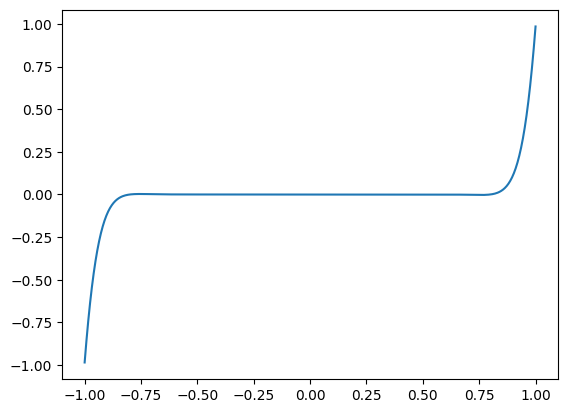

In [16]:
# Plots the response function of the extraction gadget
X, Y = G_extraction.get_response()
plt.plot(X, Y)

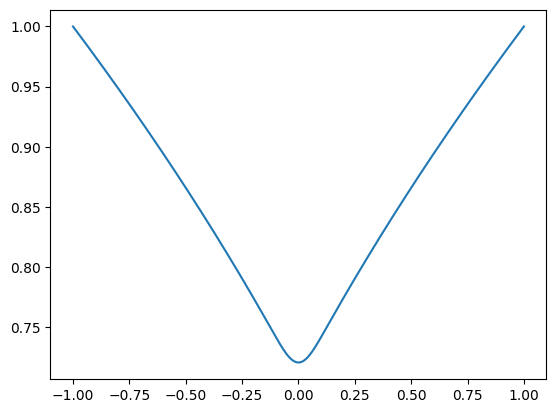

In [17]:
# Gets the response function of the sqrt gadget
X, Y = G_sqrt.get_response()
plt.plot(X, Y)

In [18]:
# Performs test which interlinks an inverse Chebyshev gadget with the second Chebyshev polynomial

G_cheb = AtomicGadget([[0, 0, 0]], [[0, 0]], label="G_cheb")
G_id = G_sqrt.interlink(G_cheb, [
    (('G_sqrt', 0), ('G_cheb', 0), None)
])

fn_2 = lambda x : G_id.get_qsp_unitary(('G_cheb', 0))({('G_sqrt', 0) : x})[0][0]
data = [fn_2(x) for x in tqdm(np.linspace(-1, 1, 200))]

  0%|          | 0/200 [00:00<?, ?it/s]

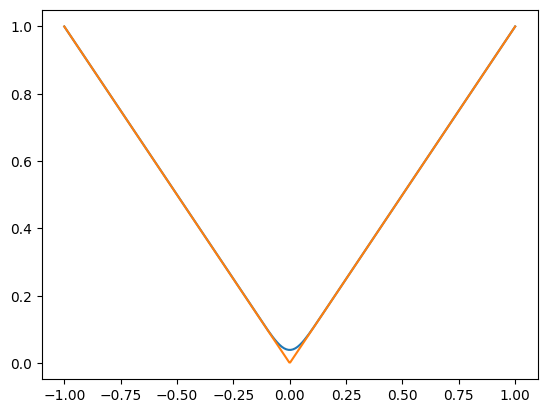

In [19]:
# IT WORKS!
plt.plot(np.linspace(-1, 1, 200), data)
plt.plot(X, np.abs(X))

In [20]:
# Tests that the arbitrary multiplication gadget works
G_mult = MultiplicationGadget("G_mult")

G_arb_mult = G_sqrt.interlink(G_mult, [
    (('G_sqrt', 0), ('G_mult', 0), None)
])

fn_3 = lambda x, y : (G_arb_mult.get_qsp_unitary(('G_mult', 0))({('G_sqrt', 0) : x, ("G_mult", 1): y}))[0][0]

In [21]:
data = [[fn_3(x, y) for x in np.linspace(-1, 1, 40)] for y in tqdm(np.linspace(-1, 1, 40))]

  0%|          | 0/40 [00:00<?, ?it/s]

In [30]:
fn_3(0.71, 0.84)

(0.5960838262618515+0.0015257352470736119j)

In [31]:
0.71 * 0.84

0.5963999999999999

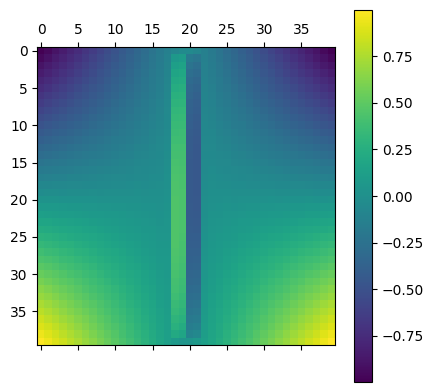

In [23]:
plt.matshow(np.real(data))
plt.colorbar()

  0%|          | 0/40 [00:00<?, ?it/s]

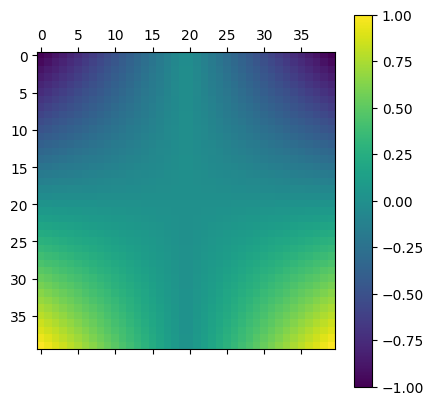

In [24]:
# Plots |x| * y

data_mult = [[np.abs(x) * y for x in np.linspace(-1, 1, 40)] for y in tqdm(np.linspace(-1, 1, 40))]
plt.matshow(np.real(data_mult))
plt.colorbar()

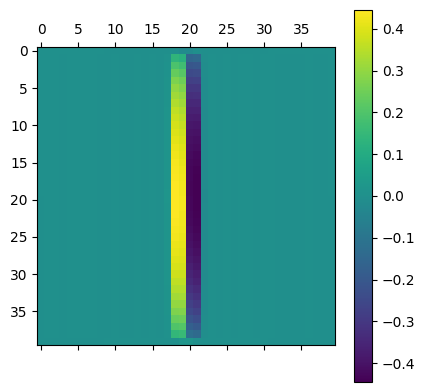

In [25]:
plt.matshow(np.real(np.array(data) - np.array(data_mult)))
plt.colorbar()

In [26]:
np.real(np.array(data) - np.array(data_mult))

array([[ 6.57674064e-06,  8.76372487e-06,  2.90453685e-05, ...,  2.90453685e-05,  8.76372487e-06,  6.57674064e-06],
       [ 6.23947189e-06,  6.15323962e-04,  6.42705704e-04, ..., -5.87593980e-04, -5.98695356e-04,  6.23947189e-06],
       [ 5.90220314e-06,  8.54935588e-04,  8.84496537e-04, ..., -8.32363825e-04, -8.39205826e-04,  5.90220314e-06],
       ...,
       [-5.90220314e-06,  8.39205826e-04,  8.32363825e-04, ..., -8.84496537e-04, -8.54935588e-04, -5.90220314e-06],
       [-6.23947189e-06,  5.98695356e-04,  5.87593980e-04, ..., -6.42705704e-04, -6.15323962e-04, -6.23947189e-06],
       [-6.57674064e-06, -8.76372487e-06, -2.90453685e-05, ..., -2.90453685e-05, -8.76372487e-06, -6.57674064e-06]])